#DiaSources Analysis

In [20]:
import lsst.meas.astrom as measAstrom
import lsst.daf.base as dafBase
import lsst.pipe.base as pipeBase
import lsst.daf.persistence as dafPersist

import random
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.display.ds9 as ds9
import lsst.afw.table as afwTable

import lsst.afw.geom as afwGeom
import lsst.afw.display.utils as displayUtils

This is the butler reference that we use on our working dataset. DATADIR is where our data is, obviously

In [21]:
#DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_v11/"
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")


We create a list with all our diaSources Catalog (one for each visit)

In [22]:
subset = butler.subset("deepDiff_diaSrc")
#file = open("diaSources.txt", "w")
diaSourcesList = []
for dr_subSet in subset:
    if dr_subSet.dataId["ccd"]==14:
        #file.write("visit="+str(dr_subSet.dataId["visit"])+"\n")
        try:
            diaSourcesList.append(dr_subSet)
           
        except:
            pass
            

#file.close()

In [23]:
dataId = {'visit': 800719, 'filter':'r' , 'ccd':14}
diaSrcs = butler.get("deepDiff_diaSrc", dataId)
diffExp = butler.get("deepDiff_differenceExp", dataId)

In [24]:
ds9.mtv(diffExp, frame=1)

In [25]:
ds = random.choice(diaSrcs)
ds.get("base_CircularApertureFlux_6_0_fluxSigma")

233.52850341796875

In [26]:
def plot_fluxes_from_diasources_list(diaSources, flux_variable, class_flux=10000, limit_flux=50000, bins=100):
   
    fluxes =[]
    sigmaPos = []
    sigmaNeg = []

    for diaSrc in diaSrcs:
    
        flux = diaSrc.get(flux_variable)
        #ds9.dot("o", x, y, size = 25, frame=3)
        x = diaSrc.get("ip_diffim_NaiveDipoleCentroid_x")
        y = diaSrc.get("ip_diffim_NaiveDipoleCentroid_y")
        if np.abs(flux) < limit_flux:
            fluxes.append(flux)
            
          
        if np.isnan(flux) == False:
            if flux > 0:
                sigmaPos.append(diaSrc.get(flux_variable+"Sigma"))
            else:
                sigmaNeg.append(diaSrc.get(flux_variable+"Sigma")) 
                
    meanSigmaPos = np.mean(sigmaPos)
    meanSigmaNeg = np.mean(sigmaNeg)
    

    
    plot_fluxes(fluxes, meanSigmaPos, meanSigmaNeg, title=flux_variable, class_flux=class_flux, limit_flux=limit_flux, bins=bins)
    

def plot_fluxes(fluxes, positive_sigma, negative_sigma, title="", class_flux=10000, limit_flux=50000, bins=100):

  
    
    N, bins, patches = plt.hist(fluxes, bins=bins)

    for bin_size, bin, patch in zip(N, bins, patches):
        if bin > class_flux:
            patch.set_facecolor('g')
        elif bin < -class_flux:
            patch.set_facecolor('r')
 


    plt.axvline(positive_sigma*5, color='y', linestyle='dashed', linewidth=2)
    plt.axvline(-(negative_sigma*5), color='y', linestyle='dashed', linewidth=2)
    plt.title(title)
    ax=plt.axes()
    ax.set_xlim(xmin=-limit_flux, xmax=limit_flux)
                
                
                
    plt.show()

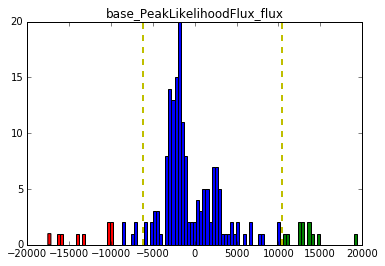

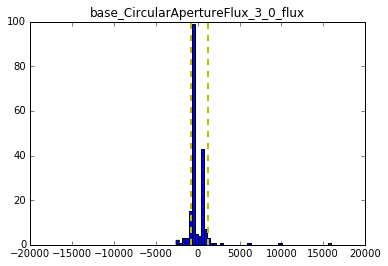

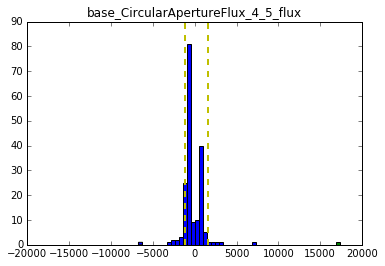

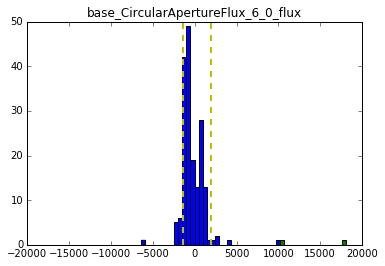

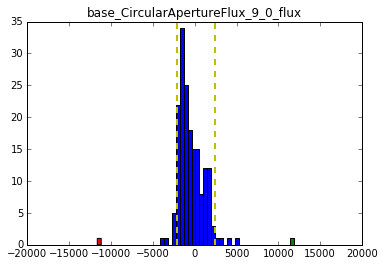

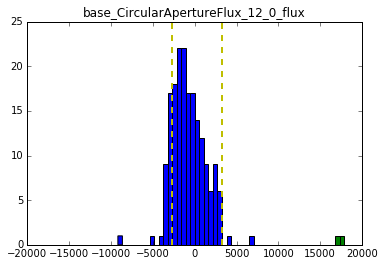

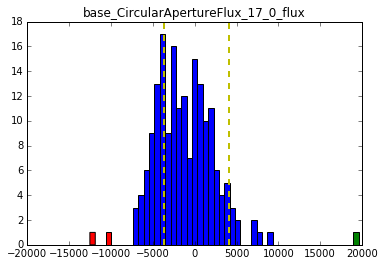

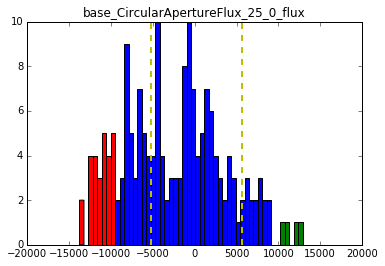

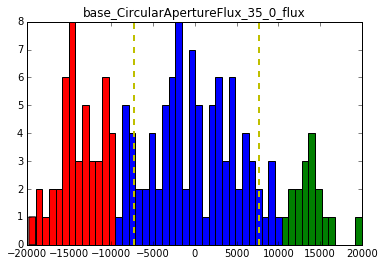

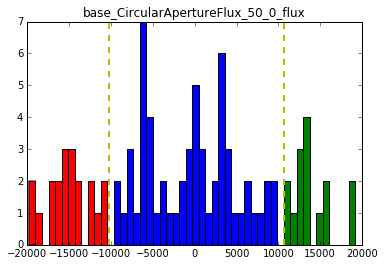

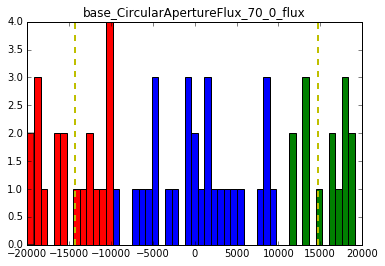

In [27]:
%matplotlib inline


plot_fluxes_from_diasources_list(diaSrcs,"base_PeakLikelihoodFlux_flux", limit_flux=20000, bins = 100)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_3_0_flux", limit_flux=20000, bins = 50)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_4_5_flux", limit_flux=20000, bins = 50)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_6_0_flux", limit_flux=20000, bins = 50)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_9_0_flux", limit_flux=20000, bins = 50)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_12_0_flux", limit_flux=20000, bins = 50)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_17_0_flux", limit_flux=20000, bins = 50)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_25_0_flux", limit_flux=20000, bins = 50)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_35_0_flux", limit_flux=20000, bins = 50)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_50_0_flux", limit_flux=20000, bins = 50)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_70_0_flux", limit_flux=20000, bins = 50)

In [28]:
ds = random.choice(diaSrcs)


In [29]:

scienceExposure =  butler.get("calexp", {"visit":800719, "ccd":14, "filter":"r"})
templateExposure = butler.get("deepDiff_warpedExp", {"visit":800719, "ccd":14, "filter":"r"})
subtractedExposure = diffExp

ds9.mtv(scienceExposure, frame=1)
ds9.mtv(templateExposure, frame=2)
ds9.mtv(subtractedExposure, frame=3)

In [30]:

def get_stamps_for_diaSource(diaSource, scienceExposure, templateExposure, subtractedExposure, show_stamps=False, frame=1):
    bbox = diaSource.getFootprint().getBBox()

    mos = displayUtils.Mosaic()
    Begin = afwGeom.Point2I(bbox.getBeginX(), bbox.getBeginY())
    End = afwGeom.Point2I(bbox.getEndX(), bbox.getEndY())

    ExpOrig = afwGeom.Point2I(scienceExposure.getX0()-1, scienceExposure.getY0()-1)



    correctedBegin = bbox.getBegin()- ExpOrig
    correctedEnd = bbox.getEnd() - ExpOrig

    correctedBegin= afwGeom.Point2I(correctedBegin.getX()-10,correctedBegin.getY()-10 )
    correctedEnd = afwGeom.Point2I(correctedEnd.getX()+10,correctedEnd.getY()+10 )



    bboxT = afwGeom.Box2I(correctedBegin,correctedEnd)

    #print bboxT.toString
    stamp_science = scienceExposure.Factory(scienceExposure,bboxT, True)
    im = displayUtils.Mosaic(gutter=5, background=5, mode="x")
    im.append(stamp_science.getMaskedImage())
    

    stamp_template = templateExposure.Factory(templateExposure,bboxT, True)
    #im = displayUtils.Mosaic(gutter=0, background=0, mode="x")
    im.append(stamp_template.getMaskedImage())
    


    stamp_subtracted = subtractedExposure.Factory(subtractedExposure,bboxT, True)
    #im = displayUtils.Mosaic(gutter=0, background=0, mode="x")
    im.append(stamp_subtracted.getMaskedImage())
    
    
    if show_stamps == True:
        ds9.mtv(stamp_science, frame=frame)
        frame+=1
        ds9.mtv(stamp_template, frame=2)
        frame+=1
        ds9.mtv(stamp_subtracted, frame=3)
        
    return stamp_science, stamp_template, stamp_subtracted

In [31]:
def get_array_from_stamp(stamp):
    mi = stamp.getMaskedImage()
    mask = mi.getMask()
    pixels_in_mask =0


    values_out = []
    values_in = []

    bitmask_detected = mask.getPlaneBitMask("DETECTED")
    bitmask_detected_neg = mask.getPlaneBitMask("DETECTED_NEGATIVE")
    #print "///"
    #print bitmask
    #print "///"

    for x in range(0, mi.getWidth()):
        
        for y in range (0, mi.getHeight()):
            if np.isnan(mi.getImage().get(x,y))==False:
                u =  mi.getMask()[x,y]

                if u.get(0,0) & bitmask_detected == 0 and u.get(0,0) & bitmask_detected_neg == 0:
                    values_out.append(mi.getImage().get(x,y))
                else:
                    values_in.append(mi.getImage().get(x,y))
                    pixels_in_mask += 1

    return values_out, values_in, pixels_in_mask

In [46]:
#

fluxes = []
fluxes_s = []
fluxes_t = []
fluxes_d = []

sigmas = []
sigmas_s =[]
sigmas_t =[]
sigmas_d = []

for ds in diaSrcs:

    flux = ds.get("base_CircularApertureFlux_6_0_flux")
    sigma = ds.get("base_CircularApertureFlux_6_0_fluxSigma")
    
    try:

        stamp_s, stamp_t, stamp_d = get_stamps_for_diaSource(ds, scienceExposure, templateExposure, subtractedExposure)


        values_out_s, values_in_s, m_pixels_s = get_array_from_stamp(stamp_s)
        values_out_t, values_in_t, m_pixels_t = get_array_from_stamp(stamp_t)
        values_out_d, values_in_d, m_pixels_d = get_array_from_stamp(stamp_d)

        fluxes.append(flux)
        fluxes_s.append(np.sum(values_in_s))
        fluxes_t.append(np.sum(values_in_t))
        fluxes_d.append(np.sum(values_in_d))

        sigmas.append(sigma)

        sigmas_s.append(np.sqrt(m_pixels_s)*np.std(values_out_s))
        sigmas_t.append(np.sqrt(m_pixels_t)*np.std(values_out_t))
        sigmas_d.append(np.sqrt(m_pixels_d)*np.std(values_out_d))
    except:
        pass

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/numpy/ma/core.py:809: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/numpy/ma/core.py:824: RuntimeWarning: invalid value encountered in less_equal
  return umath.less_equal(x, self.critical_value)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/numpy/ma/core.py:2071: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xf >= v1) & (xf <= v2)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/numpy/ma/core.py:2071: RuntimeWarning: invalid value encountered in less_equal
  condition = (xf >= v1) & (xf <= v2)


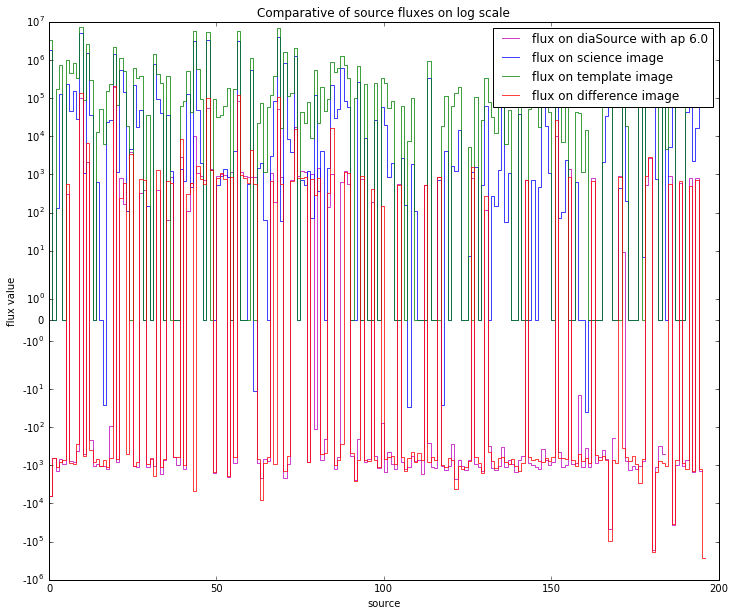

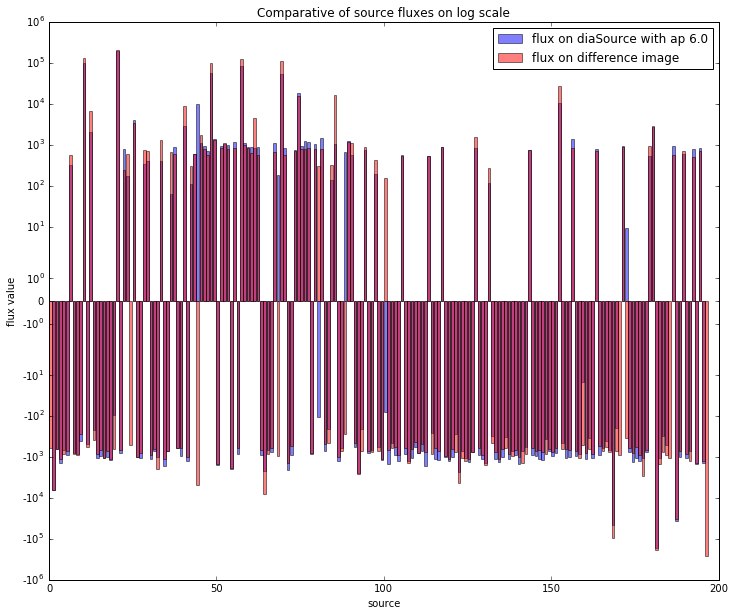

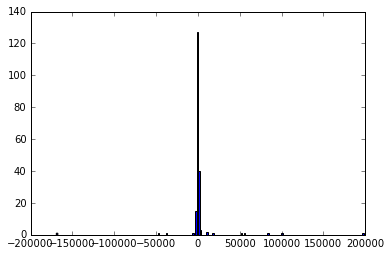

In [15]:
sources = list(range(len(fluxes)))

plt.figure(figsize=(12,10))
plt.plot(sources,fluxes, color='m', ls='steps', alpha=0.75, label='flux on diaSource with ap 6.0')
plt.plot(sources, fluxes_s, color='b', ls='steps', alpha=0.75,label='flux on science image')
plt.plot(sources, fluxes_t, color='g', ls='steps',alpha=0.75,label='flux on template image')
plt.plot(sources, fluxes_d, color='r', ls='steps',alpha=0.75,label='flux on difference image')
plt.title('Comparative of source fluxes on log scale')
plt.xlabel("source")
plt.ylabel("flux value")
plt.legend()
ax=plt.axes()
ax.set_yscale('symlog')
plt.show()

plt.figure(figsize=(12,10))
plt.bar(sources,fluxes, color='b', alpha=0.5, label='flux on diaSource with ap 6.0')
plt.bar(sources, fluxes_d, color='r', alpha=0.5,label='flux on difference image')
plt.title('Comparative of source fluxes on log scale')
plt.xlabel("source")
plt.ylabel("flux value")
plt.legend()
ax=plt.axes()
ax.set_yscale('symlog')
plt.show()

fluxes = np.nan_to_num(fluxes)

plt.hist(fluxes, bins=len(fluxes))
plt.show()

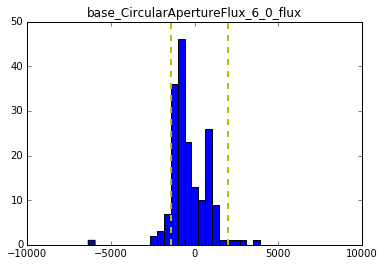

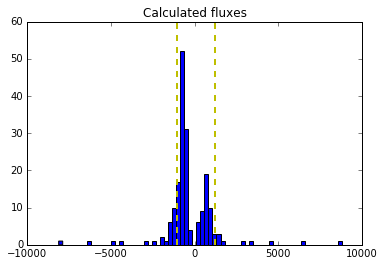

In [51]:
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_6_0_flux", limit_flux=10000, bins = 25)

sigmas_d_pos=[]
sigmas_d_neg=[]

fixed_fluxes =[]
for flux, sigma in zip(fluxes_d, sigmas_d):
    
    if np.abs(flux) < 20000:
        fixed_fluxes.append(flux)
        if np.isnan(sigma)==False:
            if flux < 0:
                sigmas_d_neg.append(sigma)
            elif flux > 0:
                sigmas_d_pos.append(sigma)
    



plot_fluxes(fixed_fluxes, np.mean(sigmas_d_pos), np.mean(sigmas_d_neg), title="Calculated fluxes", limit_flux=10000, bins = 100)

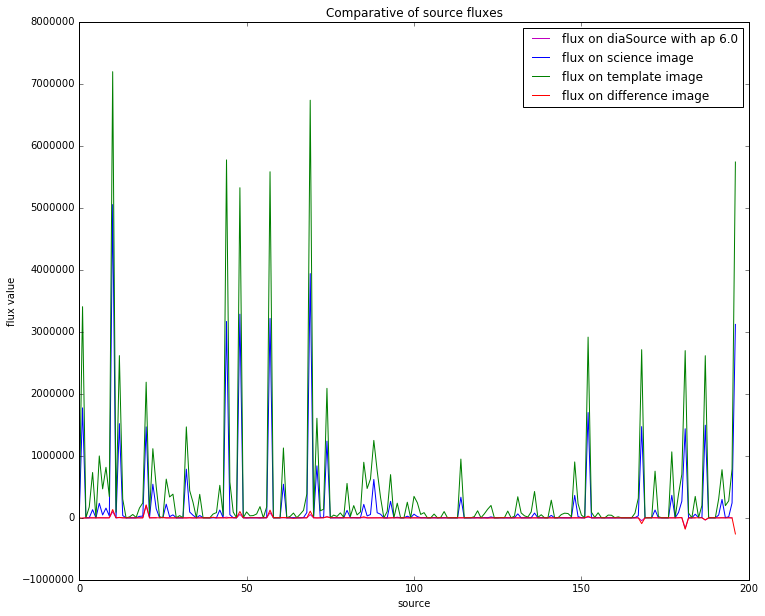

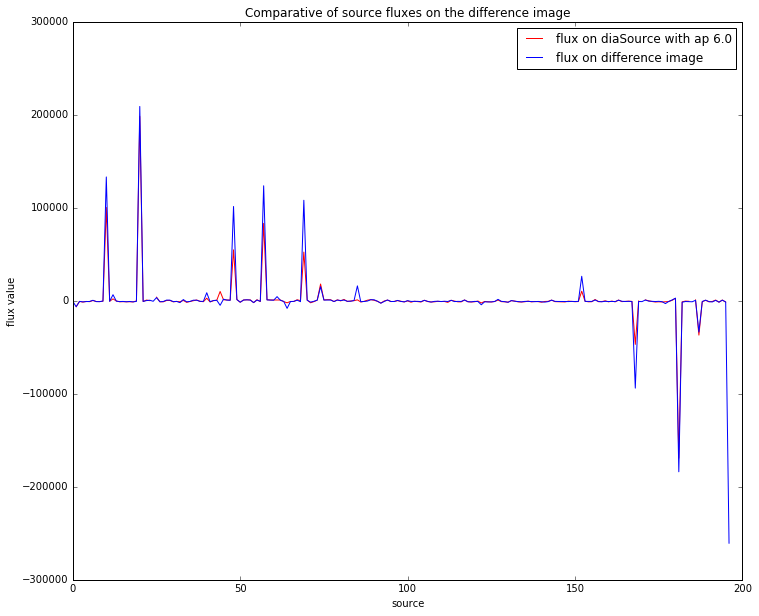

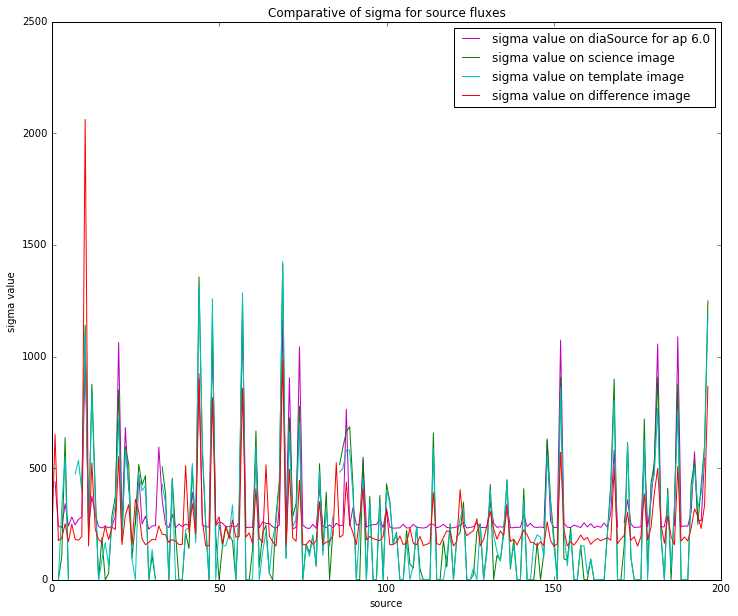

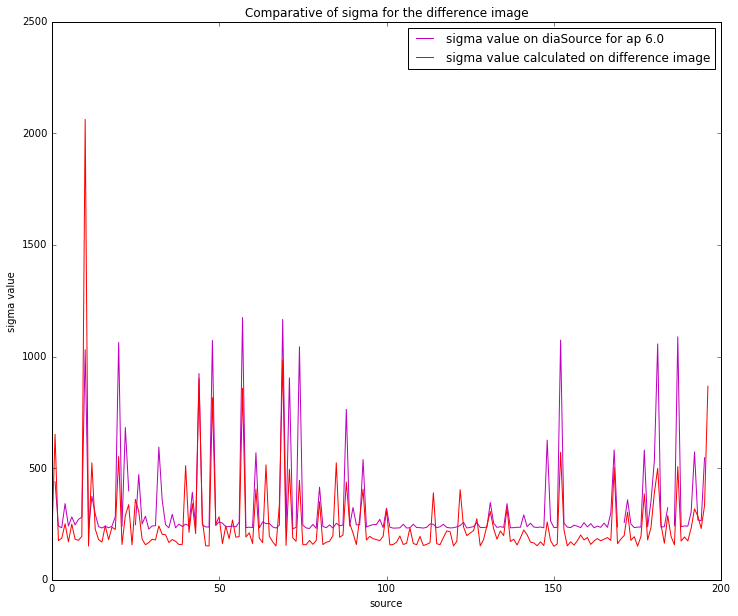

In [53]:
sources = list(range(len(fluxes)))


plt.figure(figsize=(12,10))
#plt.plot(sources, fluxes_d, 'b')
plt.plot(sources,fluxes, color='m', label='flux on diaSource with ap 6.0')
plt.plot(sources, fluxes_s, color='b', label='flux on science image')
plt.plot(sources, fluxes_t, color='g', label='flux on template image')
plt.plot(sources, fluxes_d, color='r', label='flux on difference image')
plt.title('Comparative of source fluxes')
plt.xlabel("source")
plt.ylabel("flux value")
plt.legend()
plt.show()

plt.figure(figsize=(12,10))
#plt.plot(sources, fluxes_d, 'b')
plt.plot(sources,fluxes, color='r', label='flux on diaSource with ap 6.0')
plt.plot(sources, fluxes_d, color='b', label='flux on difference image')
plt.title('Comparative of source fluxes on the difference image')
plt.xlabel("source")
plt.ylabel("flux value")
plt.legend()
plt.show()

plt.figure(figsize=(12,10))
plt.plot(sources,sigmas, 'm', label='sigma value on diaSource for ap 6.0')
plt.plot(sources, sigmas_s, 'g', label='sigma value on science image')
plt.plot(sources, sigmas_t, 'c', label='sigma value on template image')
plt.plot(sources, sigmas_d, 'r', label='sigma value on difference image')
plt.title('Comparative of sigma for source fluxes')
plt.xlabel("source")
plt.ylabel("sigma value")
plt.legend()
plt.show()


plt.figure(figsize=(12,10))
plt.plot(sources,sigmas, 'm', label='sigma value on diaSource for ap 6.0')
plt.plot(sources, sigmas_d, 'r', label='sigma value calculated on difference image')
plt.title('Comparative of sigma for the difference image')
plt.xlabel("source")
plt.ylabel("sigma value")
plt.legend()
ax=plt.axes()
ax.set_ylim(ymin=0)
plt.show()

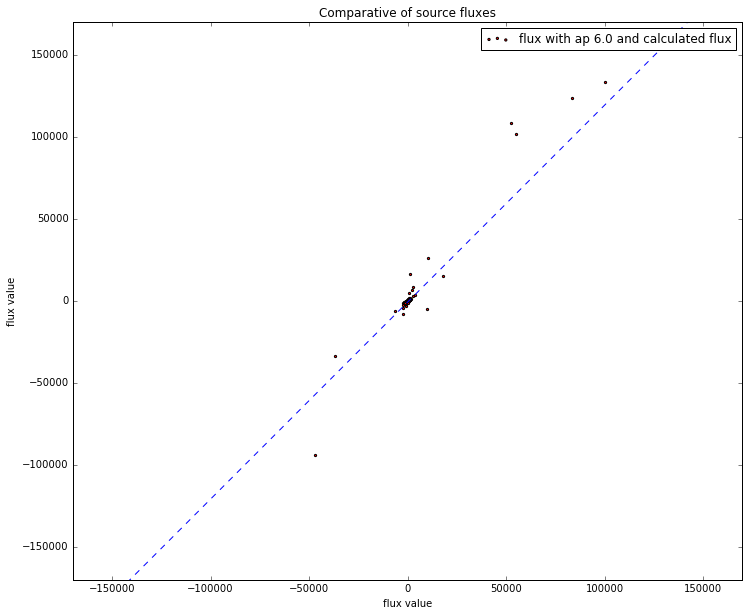

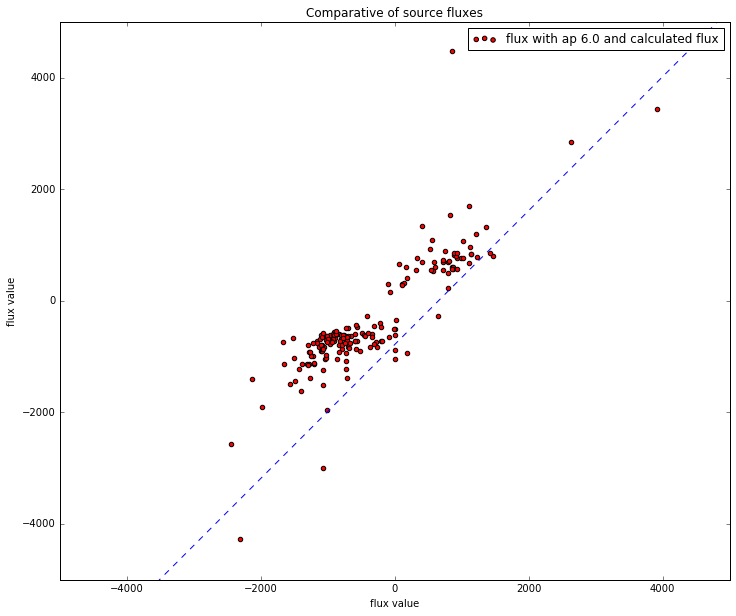

In [18]:
sources = list(range(len(fluxes)))

z = np.polyfit(fluxes,fluxes_d,1)
p = np.poly1d(z)

fmax = np.max(fluxes)
fmin = np.min(fluxes)
plt.figure(figsize=(12,10))
#plt.plot(sources, fluxes_d, 'b')
plt.scatter(fluxes,fluxes_d, c='r', s=5, label='flux with ap 6.0 and calculated flux')
#plt.plot(sources, fluxes_s, color='b', label='flux on science image')
#plt.plot(sources, fluxes_t, color='g', label='flux on template image')
#plt.plot(sources, fluxes_d, color='r', label='flux on difference image')
plt.title('Comparative of source fluxes')
plt.xlabel("flux value")
plt.ylabel("flux value")
plt.plot([fmin, fmax],[p(fmin), p(fmax)], 'b--')
ax = plt.axes()
ax.set_xlim(xmin=-170000, xmax=170000)
ax.set_ylim(ymin=-170000, ymax=170000)
plt.legend()
plt.show()

plt.figure(figsize=(12,10))
#plt.plot(sources, fluxes_d, 'b')
plt.scatter(fluxes,fluxes_d, c='r', s=20, label='flux with ap 6.0 and calculated flux')
#plt.plot(sources, fluxes_s, color='b', label='flux on science image')
#plt.plot(sources, fluxes_t, color='g', label='flux on template image')
#plt.plot(sources, fluxes_d, color='r', label='flux on difference image')
plt.title('Comparative of source fluxes')
plt.xlabel("flux value")
plt.ylabel("flux value")
plt.plot([fmin, fmax],[p(fmin), p(fmax)], 'b--')
ax = plt.axes()
ax.set_xlim(xmin=-5000, xmax=5000)
ax.set_ylim(ymin=-5000, ymax=5000)
plt.legend()
plt.show()


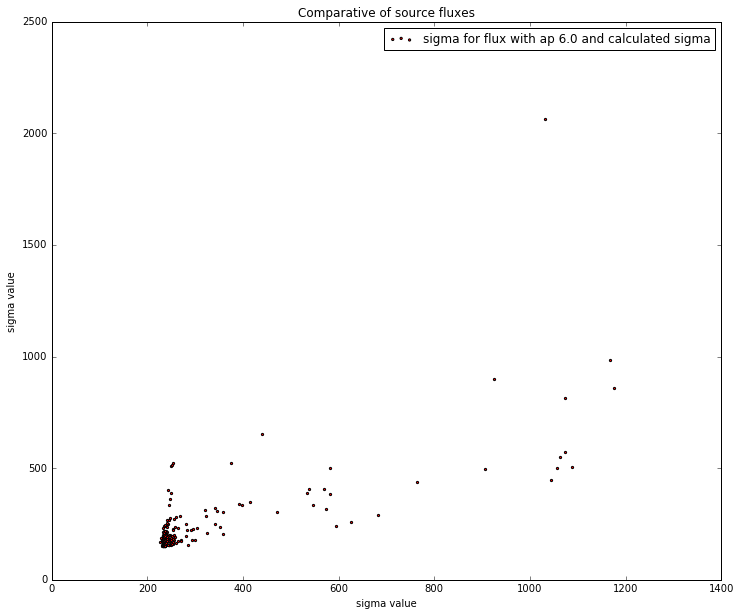

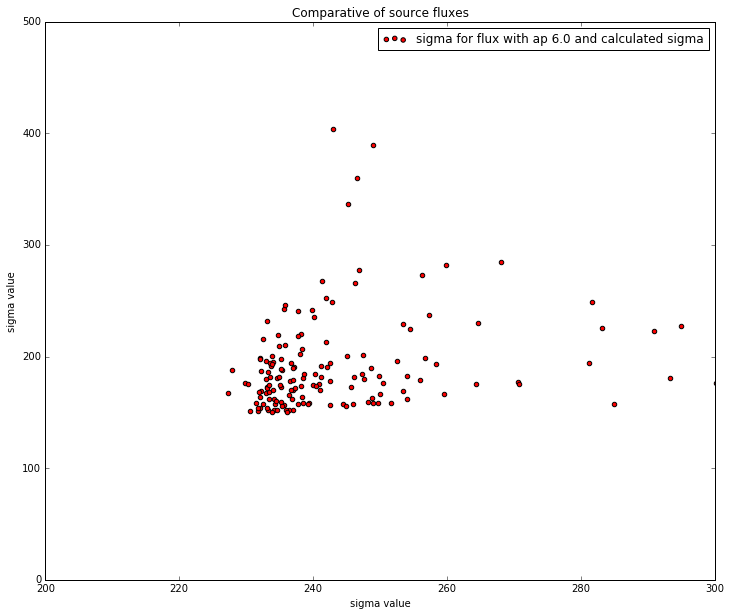

In [48]:
sources = list(range(len(fluxes)))



fmax = np.max(sigmas)
fmin = np.min(sigmas)
plt.figure(figsize=(12,10))
#plt.plot(sources, fluxes_d, 'b')
plt.scatter(sigmas,sigmas_d, c='r', s=5, label='sigma for flux with ap 6.0 and calculated sigma')
#plt.plot(sources, fluxes_s, color='b', label='flux on science image')
#plt.plot(sources, fluxes_t, color='g', label='flux on template image')
#plt.plot(sources, fluxes_d, color='r', label='flux on difference image')
plt.title('Comparative of source fluxes')
plt.xlabel("sigma value")
plt.ylabel("sigma value")
#plt.plot([fmin, fmax],[p(fmin), p(fmax)], 'b--')
ax = plt.axes()
#ax.set_xlim(xmin=-170000, xmax=170000)
#ax.set_ylim(ymin=-170000, ymax=170000)
plt.legend()
plt.show()

plt.figure(figsize=(12,10))
#plt.plot(sources, fluxes_d, 'b')
plt.scatter(sigmas,sigmas_d, c='r', s=20, label='sigma for flux with ap 6.0 and calculated sigma')
#plt.plot(sources, fluxes_s, color='b', label='flux on science image')
#plt.plot(sources, fluxes_t, color='g', label='flux on template image')
#plt.plot(sources, fluxes_d, color='r', label='flux on difference image')
plt.title('Comparative of source fluxes')
plt.xlabel("sigma value")
plt.ylabel("sigma value")
#plt.plot([fmin, fmax],[p(fmin), p(fmax)], 'b--')
ax = plt.axes()
ax.set_xlim(xmin=200, xmax=300)
ax.set_ylim(ymin=0, ymax=500)
plt.legend()
plt.show()


In [ ]:
ds9.mtv(stamp_science, frame = 1)
ds9.mtv(stamp, frame=2)
ds9.mtv(scienceExposure, frame=3)

In [ ]:
bX = bboxT.getBeginX()
bY = bboxT.getBeginY()
eX = bboxT.getEndX()
eY = bboxT.getEndY()


ds9.line([(bX,bY), (bX, eY)], frame=3,ctype='red')
ds9.line([(bX,eY), (eX, eY)], frame=3,ctype='red')
ds9.line([(eX,eY), (eX, bY)], frame=3,ctype='red')
ds9.line([(eX,bY), (bX, bY)], frame=3,ctype='red')

In [ ]:
im.makeMosaic(frame=7, title="mosaic")

In [ ]:
bX = bboxT.getBeginX()
bY = bboxT.getBeginY()
eX = bboxT.getEndX()
eY = bboxT.getEndY()
   
ds9.line([(bX,bY), (bX, eY)], frame=1,ctype='red')
ds9.line([(bX,eY), (eX, eY)], frame=1,ctype='red')
ds9.line([(eX,eY), (eX, bY)], frame=1,ctype='red')
ds9.line([(eX,bY), (bX, bY)], frame=1,ctype='red')

ds9.line([(bX,bY), (bX, eY)], frame=2,ctype='red')
ds9.line([(bX,eY), (eX, eY)], frame=2,ctype='red')
ds9.line([(eX,eY), (eX, bY)], frame=2,ctype='red')
ds9.line([(eX,bY), (bX, bY)], frame=2,ctype='red')

ds9.line([(bX,bY), (bX, eY)], frame=3,ctype='red')
ds9.line([(bX,eY), (eX, eY)], frame=3,ctype='red')
ds9.line([(eX,eY), (eX, bY)], frame=3,ctype='red')
ds9.line([(eX,bY), (bX, bY)], frame=3,ctype='red')


In [ ]:
scienceExposure =  diaSourcesCatalog.get("calexp")
ExpOrig = afwGeom.Point2I(scienceExposure.getX0()-1, scienceExposure.getY0()-1)

for ds in ds_list:
    bbox = ds.getFootprint().getBBox()
    Begin = afwGeom.Point2I(bbox.getBeginX(), bbox.getBeginY())
    End = afwGeom.Point2I(bbox.getEndX(), bbox.getEndY())
    correctedBegin = bbox.getBegin()- ExpOrig
    correctedEnd = bbox.getEnd() - ExpOrig

    correctedBegin= afwGeom.Point2I(correctedBegin.getX()-10,correctedBegin.getY()-10 )
    correctedEnd = afwGeom.Point2I(correctedEnd.getX()+10,correctedEnd.getY()+10 )
    
    bboxT = afwGeom.Box2I(correctedBegin,correctedEnd)
    
    bX = bboxT.getBeginX()
    bY = bboxT.getBeginY()
    eX = bboxT.getEndX()
    eY = bboxT.getEndY()
    
    ds9.line([(bX,bY), (bX, eY)], frame=1,ctype='red')
    ds9.line([(bX,eY), (eX, eY)], frame=1,ctype='red')
    ds9.line([(eX,eY), (eX, bY)], frame=1,ctype='red')
    ds9.line([(eX,bY), (bX, bY)], frame=1,ctype='red')
    
    #ds9.line([(bX,bY), (bX, eY)], frame=3,ctype='red')
    #ds9.line([(bX,eY), (eX, eY)], frame=3,ctype='red')
    #ds9.line([(eX,eY), (eX, bY)], frame=3,ctype='red')
    #ds9.line([(eX,bY), (bX, bY)], frame=3,ctype='red')

In [ ]:
#ds9.mtv(subtractedExposure, frame=4)
im.makeMosaic(frame=4, title="mosaic")

In [ ]:
bX = bboxT.getBeginX()
bY = bboxT.getBeginY()
eX = bboxT.getEndX()
eY = bboxT.getEndY()

In [ ]:
ds9.line([(bX,bY), (bX, eY)], frame=5,ctype='red')
ds9.line([(bX,eY), (eX, eY)], frame=5,ctype='red')
ds9.line([(eX,eY), (eX, bY)], frame=5,ctype='red')
ds9.line([(eX,bY), (bX, bY)], frame=5,ctype='red')

In [ ]:
ds9.line([(bX,bY), (bX, eY)], frame=6,ctype='red')
ds9.line([(bX,eY), (eX, eY)], frame=6,ctype='red')
ds9.line([(eX,eY), (eX, bY)], frame=6,ctype='red')
ds9.line([(eX,bY), (bX, bY)], frame=6,ctype='red')

In [ ]:
ds9.line([(bX,bY), (bX, eY)], frame=7,ctype='red')
ds9.line([(bX,eY), (eX, eY)], frame=7,ctype='red')
ds9.line([(eX,eY), (eX, bY)], frame=7,ctype='red')
ds9.line([(eX,bY), (bX, bY)], frame=7,ctype='red')

In [ ]:
ds9.dot("o",ds.get("ip_diffim_NaiveDipoleCentroid_pos_x") - scienceExposure.getX0(), ds.get("ip_diffim_NaiveDipoleCentroid_pos_y") - scienceExposure.getY0(), frame=5, size = 25, ctype = ds9.RED)
ds9.dot("o",ds.get("ip_diffim_NaiveDipoleCentroid_pos_x") - scienceExposure.getX0(), ds.get("ip_diffim_NaiveDipoleCentroid_pos_y") - scienceExposure.getY0(), frame=6, size = 25, ctype = ds9.RED)
ds9.dot("o",ds.get("ip_diffim_NaiveDipoleCentroid_pos_x") - scienceExposure.getX0(), ds.get("ip_diffim_NaiveDipoleCentroid_pos_y") - scienceExposure.getY0(), frame=7, size = 25, ctype = ds9.RED)